In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.style.use('mympl')

In [2]:
results = pd.read_csv("../data/runs.csv", usecols=[3] + list(range(8, 18)))
results['Run ID'] = np.repeat(list(range(10)), 19)
results = results.query("Name not in ['Anchor RCP', 'Knowledge distillation']")

In [3]:
baseline_results = results.query("Name == 'Baseline'")
anchor_results = results.query("Name.str.contains('ARCP')")
distillation_results = results.query("Name.str.contains('KD')")

In [4]:
cols = ['accuracy', 'churn', 'good_churn', 'bad_churn', 'win_loss_ratio']
baseline_results = baseline_results.groupby(['Run ID'], as_index=False)[cols].mean()
baseline_results = baseline_results[cols].mean(axis=0)
baseline_results.head()

accuracy          0.656024
churn             0.101203
good_churn        0.051006
bad_churn         0.050197
win_loss_ratio    1.019088
dtype: float64

In [5]:
anchor_results = (anchor_results
 .groupby(['alpha', 'eps'], as_index=False)[cols + ['churn_ratio_anchor']]
 .agg(['mean', 'std'])
 .reset_index())
anchor_results.head()

alpha  eps  accuracy               churn           good_churn            \
                  mean       std      mean       std       mean       std   
0   0.2  0.6  0.656325  0.006098  0.069401  0.006640   0.035255  0.003612   
1   0.2  0.8  0.657134  0.005320  0.080288  0.004957   0.041103  0.002340   
2   0.2  1.0  0.657414  0.004557  0.099316  0.008812   0.050757  0.005223   
3   0.4  0.6  0.657082  0.004586  0.064932  0.004691   0.033399  0.002362   
4   0.4  0.8  0.658689  0.006363  0.074710  0.006492   0.039092  0.003290   

  bad_churn           win_loss_ratio           churn_ratio_anchor            
       mean       std           mean       std               mean       std  
0  0.034146  0.003499       1.035021  0.078549           0.687134  0.057460  
1  0.039185  0.003130       1.052494  0.068147           0.796963  0.067832  
2  0.048559  0.004828       1.049155  0.099427           0.984948  0.093905  
3  0.031533  0.002791       1.063004  0.074183           0.645602  0.070729  
4  0.035618  0.004026       1.105193  0.105474           0.742519  0.083787

In [6]:
distillation_results = (distillation_results
                  .groupby(['lambda'], as_index=False)[cols + ['churn_ratio_distillation']]
                  .agg(['mean', 'std'])
                  .reset_index())
distillation_results.head()

lambda  accuracy               churn           good_churn            \
              mean       std      mean       std       mean       std   
0    0.2  0.657041  0.004950  0.092659  0.008215   0.047242  0.004455   
1    0.4  0.657549  0.005499  0.080371  0.008090   0.041352  0.004210   
2    0.6  0.658295  0.005442  0.065979  0.004171   0.034529  0.002502   
3    0.8  0.657041  0.006158  0.050975  0.004948   0.026400  0.002620   

  bad_churn           win_loss_ratio           churn_ratio_distillation  \
       mean       std           mean       std                     mean   
0  0.045417  0.004348       1.042407  0.072057                 0.919567   
1  0.039019  0.004220       1.062108  0.064049                 0.799674   
2  0.031450  0.002310       1.100351  0.074066                 0.656079   
3  0.024575  0.002769       1.079182  0.089093                 0.506441   

             
        std  
0  0.095435  
1  0.105276  
2  0.066351  
3  0.060317

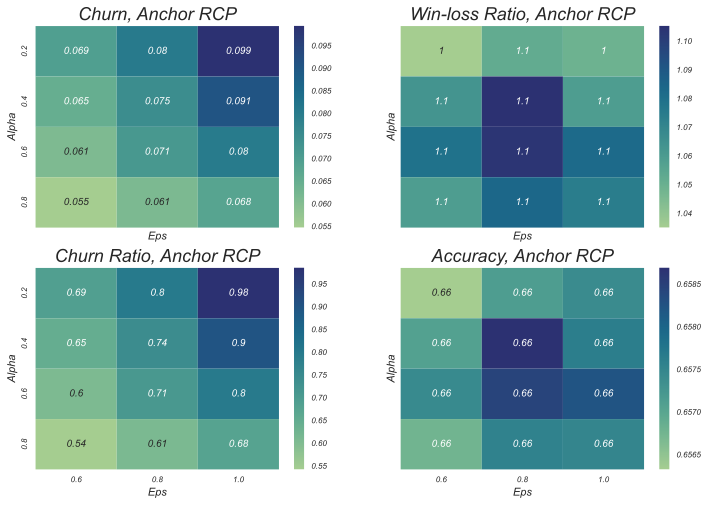

In [7]:
cols = ['0.6', '0.8', '1.0']
anchor_churn = pd.pivot(anchor_results, index='alpha', columns='eps', values=[('churn', 'mean')])
anchor_churn.columns = cols
anchor_wl = pd.pivot(anchor_results, index='alpha', columns='eps', values=[('win_loss_ratio', 'mean')])
anchor_wl.columns = cols
anchor_cr = pd.pivot(anchor_results, index='alpha', columns='eps', values=[('churn_ratio_anchor', 'mean')])
anchor_cr.columns = cols
anchor_acc = pd.pivot(anchor_results, index='alpha', columns='eps', values=[('accuracy', 'mean')])
anchor_acc.columns = cols

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
sns.heatmap(anchor_churn,
            annot=True,
            cmap='crest',
            ax=ax[0][0]).set(xlabel='Eps', ylabel='Alpha', title='Churn, Anchor RCP')
sns.heatmap(anchor_wl,
            annot=True,
            cmap='crest',
            ax=ax[0][1]).set(xlabel='Eps', ylabel='Alpha', title='Win-loss Ratio, Anchor RCP')
sns.heatmap(anchor_cr,
            annot=True,
            cmap='crest',
            ax=ax[1][0]).set(xlabel='Eps', ylabel='Alpha', title='Churn Ratio, Anchor RCP')
sns.heatmap(anchor_acc,
            annot=True,
            cmap='crest',
            ax=ax[1][1]).set(xlabel='Eps', ylabel='Alpha', title='Accuracy, Anchor RCP')
plt.show()

In [8]:
ch_anc = (anchor_results
          .groupby('alpha', as_index=False)[[('churn', 'mean'), ('churn', 'std')]]
          .mean())
wl_anc = (anchor_results
          .groupby('alpha', as_index=False)[[('win_loss_ratio', 'mean'), ('win_loss_ratio', 'std')]]
          .mean())
cr_anc = (anchor_results
          .groupby('alpha', as_index=False)[[('churn_ratio_anchor', 'mean'), ('churn_ratio_anchor', 'std')]]
          .mean())
acc_anc = (anchor_results
           .groupby('alpha', as_index=False)[[('accuracy', 'mean'), ('accuracy', 'std')]]
           .mean())

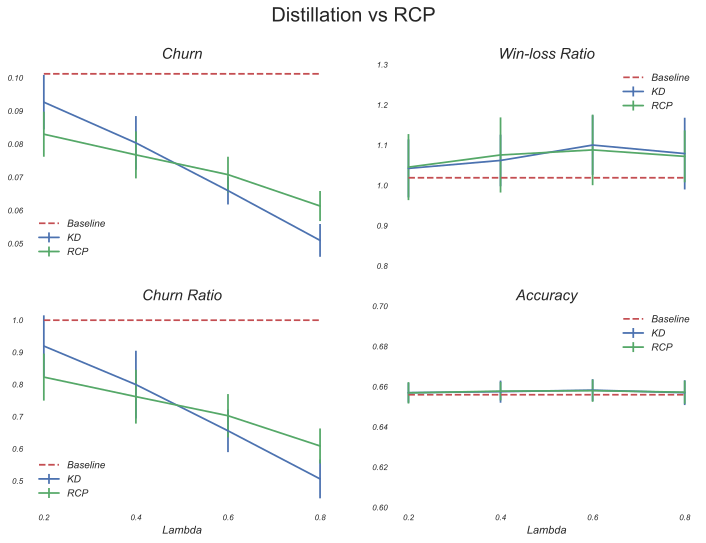

In [9]:
fig, ax = plt.subplots(2, 2, sharex=True)
ld = [0.2, 0.4, 0.6, 0.8]
ax[0][0].errorbar(distillation_results['lambda'],
                  distillation_results[('churn', 'mean')],
                  yerr=distillation_results[('churn', 'std')], label='KD')
ax[0][0].errorbar(ch_anc['alpha'],
                  ch_anc[('churn', 'mean')],
                  yerr=ch_anc[('churn', 'std')],
                  label='RCP')
ax[0][0].plot(ld, np.repeat(baseline_results['churn'], 4), '--', label='Baseline')
ax[0][0].legend()
ax[0][1].errorbar(distillation_results['lambda'],
                  distillation_results[('win_loss_ratio', 'mean')],
                  yerr=distillation_results[('win_loss_ratio', 'std')],
                  label='KD')
ax[0][1].errorbar(wl_anc['alpha'],
                  wl_anc[('win_loss_ratio', 'mean')],
                  yerr=wl_anc[('win_loss_ratio', 'std')],
                  label='RCP')
ax[0][1].plot(ld, np.repeat(baseline_results['win_loss_ratio'], 4), '--', label='Baseline')
ax[0][1].legend()
ax[1][0].errorbar(distillation_results['lambda'],
                  distillation_results[('churn_ratio_distillation', 'mean')],
                  yerr=distillation_results[('churn_ratio_distillation', 'std')],
                  label='KD')
ax[1][0].errorbar(cr_anc['alpha'],
                  cr_anc[('churn_ratio_anchor', 'mean')],
                  yerr=cr_anc[('churn_ratio_anchor', 'std')],
                  label='RCP')
ax[1][0].plot(ld, np.repeat(1, 4), '--', label='Baseline')
ax[1][0].legend()
ax[1][1].errorbar(distillation_results['lambda'],
                  distillation_results[('accuracy', 'mean')],
                  yerr=distillation_results[('accuracy', 'std')], label='KD')
ax[1][1].errorbar(acc_anc['alpha'],
                  acc_anc[('accuracy', 'mean')],
                  yerr=acc_anc[('accuracy', 'std')],
                  label='RCP')
ax[1][1].plot(ld, np.repeat(baseline_results['accuracy'], 4), '--', label='Baseline')
ax[1][1].legend()
fig.suptitle("Distillation vs RCP", fontsize=20, style='normal')
ax[0][0].set_title("Churn", fontsize=15)
ax[0][1].set_title("Win-loss Ratio", fontsize=15)
ax[1][0].set_title("Churn Ratio", fontsize=15)
ax[1][1].set_title("Accuracy", fontsize=15)
ax[1][0].set_xlabel("Lambda")
ax[1][1].set_xlabel("Lambda")
ax[1][0].set_xticks(ld)
ax[0][1].set_ylim(0.8, 1.3)
ax[1][1].set_ylim(0.6, 0.7)
plt.show()